**Parameter Estimation**


In [1]:
%load_ext autoreload
%autoreload 2

#hsvs includes
from hsvs.tools import dataset, framed_audio, magnitude, synthesis
from hsvs.model import TemporalVarianceLayer, ParameterLayer, BSplineLayer, ZPKToMagLayer, LFRdLayer, util
import hsvs

# 3rd party dependencies
import math
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import scipy.io as sio
from tqdm.notebook import tqdm

import soundfile

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
vowel  = 'a'  # [a,e,i,o,u]
singer = 'm4' # [f1 - f9, m1-m11]

# collecting sorce / output file paths 
singer_vowel_dir
source_file = dataset.get_sample('scales', 'slow_forte', vowel, singer)[0]
data_path   = os.path.abspath(os.path.join(os.path.dirname(hsvs.__file__), os.pardir, 'data'))
json_file   = os.path.join(data_path, 'results', singer_vowel_dir, 'audio.json' )
mat_file    = os.path.join(data_path, 'results', singer_vowel_dir, 'parameters.mat' )
wav_file    = os.path.join(data_path, 'results', singer_vowel_dir, 'audio', 'synthesis_estimated.wav' )

# loading stored audio object
audio = framed_audio.FramedAudio.from_json(json_file, wav_replacement=source_file)

# run onset / offset analysis, add some margin to the values
onset, offset = magnitude.get_onset_offset(audio)
onset  += 50
offset -= 50

# prepare vectors for input (pitch) and output (overtone decibel magnitude)
overtones = audio.get_trajectory('overtones')[onset:offset, :]
pitch     = np.expand_dims(audio.get_trajectory('pitch')[onset:offset],1)

num_overtones = overtones.shape[1]
num_samples = pitch.shape[0]
sample_rate = audio.fs

**Tensorflow Keras Model**

The tensorflow keras model consists of three branches that calculate the decibel response of gain, glottal flow (LF Rd model) and vocal tract (pole/zero). These are combined additively to calculate the models overtone amplitudes in decibel. Parameter trajectory are modeled as 3rd order B-Spline with varying number of B-Spline parameters per frame. Temporal variance loss is introduced in addition to the decibel magnitude loss (weighted mse) to prevent temporal overfitting of parameter trajectories.  

In [3]:
# create network to be used to parameter estimation

# vocal tract filter parameters 
num_poles_zeros = 10  
num_vt_parameters  = 4 * num_poles_zeros          

# number of bspline samples to model parameter Trajectories       
pz_b_spline_size   = math.ceil(num_samples / 10) 
Rd_b_spline_size   = math.ceil(num_samples / 10)
gain_b_spline_size = math.ceil(num_samples / 10)

# clear seesion to prevent clutter from previously compiled models
tf.keras.backend.clear_session()

# dummy input used for ZPK layer to have access to pitch
inputs = tf.keras.Input(shape=(1,), name='input')

# pole/zero (pz) branch
var_pz = TemporalVarianceLayer.TemporalVarianceLayer(num_samples = pz_b_spline_size, weight=10E8) 
x_pz = ParameterLayer.ParameterLayer(pz_b_spline_size, num_vt_parameters, initial_value=0.)(inputs) 
x_pz = var_pz(x_pz)
x_pz = BSplineLayer.BSplineLayer(pz_b_spline_size, num_samples)(x_pz)

x_pz, _, _, _ = ZPKToMagLayer.ZPKToMagLayer(sample_rate, num_overtones, name='PZ')([x_pz, inputs])
x_pz = util.MagToDBLayer()(x_pz)

# Rd branch
var_Rd = TemporalVarianceLayer.TemporalVarianceLayer(num_samples = Rd_b_spline_size, weight=10E8) 
x_Rd = ParameterLayer.ParameterLayer(Rd_b_spline_size, 1, initial_value=0.7)(inputs)
x_Rd = var_Rd(x_Rd)
x_Rd = BSplineLayer.BSplineLayer(Rd_b_spline_size, num_samples)(x_Rd)
x_Rd = tf.keras.layers.Lambda(lambda x: util.lin_scale(tf.sigmoid(x), 0., 1., 0.3, 2.7), name="Rd")(x_Rd)
x_Rd = LFRdLayer.LFRdLayer(num_overtones, name="RdOut")(x_Rd)
x_Rd = util.MagToDBLayer()(x_Rd)

# gain branch
var_gain = TemporalVarianceLayer.TemporalVarianceLayer(num_samples = gain_b_spline_size, weight=10E8) 
x_gain = ParameterLayer.ParameterLayer(gain_b_spline_size, 1, initial_value=0.5)(inputs)
x_gain = var_gain(x_gain)
x_gain = BSplineLayer.BSplineLayer(gain_b_spline_size, num_samples)(x_gain)
x_gain = tf.keras.layers.Lambda(lambda x: util.lin_scale(x, 0., 1., -100, 0), name="gain")(x_gain) # gain scaling
x_gain = tf.keras.layers.Lambda(lambda x: tf.tile(x, [1, num_overtones]))(x_gain) # tiling to fit dimensions

# gain layer to "hide" Rd branch ininitially to improve fitting
Rd_gain = util.GainLayer()
x_Rd = Rd_gain(x_Rd)

# model prediction H = H_vt * H_gf * gain or equivalent addition in decibel domain
x = tf.keras.layers.Add()([x_pz, x_gain, x_Rd])

# define network model
model = tf.keras.Model(inputs=inputs, outputs=[x])
  

**Model Compilation**

In addition to the temporal variance loss, the main loss is calculated from the mean squared error of weighted overtone amplitudes in decibel. For weighting, a -6dB / octave low pass filter (cutoff = 2kHz) is used to.  
Adam ist used as an optimizer.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
parameter_layer_1 (ParameterLay (826, 1)             1           input[0][0]                      
__________________________________________________________________________________________________
temporal_variance_layer_1 (Temp (826, 1)             826         parameter_layer_1[0][0]          
__________________________________________________________________________________________________
parameter_layer (ParameterLayer (826, 40)            40          input[0][0]                      
______________________________________________________________________________________________

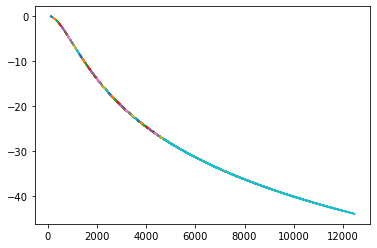

In [4]:
# variance loss weights for pole/zero, gain and Rd parameters
var_pz.weight  = 10E8
var_gain.weight = 10E0
var_Rd.weight   = 10E0

# set Rd mix
Rd_gain.gain.assign(1.)

# constructing a weight matrix with a -6dB/oct lowpass
fc = 1000.
fk = pitch * np.arange(1, 41) 
weights = tf.cast(tf.abs(1. / (1. + 1j * fk/fc)), dtype='float32')
weights = weights * weights
plt.plot(fk, util.mag2db(tf.abs(weights)).numpy())
weights /=tf.reduce_mean(tf.reduce_mean(weights, axis=1))

#compile model with learning rate and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10E-4),
    loss= lambda y_true, y_pred: util.weighted_mse_loss(y_true, y_pred, weights))

#print model summary
model.summary()

**Training**

The first few epoches are trained without the impact of LF-Rd, basically reducing the model to an source-filter with flat excitation. This is done to prevent overfitting certain frequency ranges. 

In [5]:
num_epochs = 16000

# custom tqdm progress par to reduce logging noise
pbar = tqdm(total=num_epochs)
def tqdm_update(epoch, logs):
    pbar.update()
    pbar.set_postfix_str("Loss: %s" % logs['loss'])

model.fit(x=pitch, y=overtones, 
          shuffle=False,
          epochs=num_epochs, 
          batch_size=num_samples,
          callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=tqdm_update)],
          verbose=0)
pbar.close()



Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().



** Training w/ Rd**

The following cell runs the trianing while gradually adding the LF-Rd decibel offset to the model.

In [6]:

# update allowed filter variance
var_pz.weight  = 10E7

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10E-4),
    loss= lambda y_true, y_pred: util.weighted_mse_loss(y_true, y_pred, weights))

num_epochs = 8000

# custom tqdm progress par to reduce logging noise
pbar = tqdm(total=num_epochs)
def tqdm_update(epoch, logs):
    pbar.update()
    pbar.set_postfix_str("Loss: %s" % logs['loss'])

model.fit(x=pitch, y=overtones, 
        shuffle=False,
        epochs=num_epochs, 
        batch_size=num_samples,
        callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=tqdm_update)],
        verbose=0)
pbar.close()


In [7]:

# extract parameter trajectories from model
_, z0_out, p0_out, _ = model.get_layer('PZ').output
RdOut_out = model.get_layer('RdOut').output
Rd_out    = model.get_layer('Rd').output
gain_out  = model.get_layer('gain').output
zpk_model = tf.keras.models.Model(inputs=model.input, outputs=[z0_out, p0_out, Rd_out, RdOut_out, gain_out])

[z0_pred, p0_pred, Rd_pred, RdOut_pred, gain_pred] = zpk_model.predict(pitch, batch_size=num_samples)

# store as .mat file
sio.savemat(mat_file, {
    'f':pitch,          # pitch
    'g':gain_pred,          # gain
    'Rd':Rd_pred,           # Rd parameter
    'z0':z0_pred,           # filter zeros
    'p0': p0_pred,           # filter zeros
    'fs': audio.fs,           # filter zeros
    'ot': overtones})          # filter poles

In [8]:
# synthesis with estimated parameters
x = synthesis.run(pitch, Rd_pred, gain_pred, p0_pred, z0_pred, fs=audio.fs, hop_size=64, verbose=True)

processing source
processing gain
processing filter
100%|██████████| 528384/528384 [01:11<00:00, 7438.88it/s]


In [9]:
# create dirs if they don't exist yet
audio_path = os.path.dirname(wav_file)
if not os.path.exists(audio_path):
            os.makedirs(audio_path)
            
# store synthesized audio 
soundfile.write(wav_file, x * (0.5/max(abs(x))), int(audio.fs))